In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 3})
sns.set_style('whitegrid',
              {'grid.linestyle': ':', 'grid.color': 'red', 'axes.edgecolor': '0.5',
               'axes.linewidth': 1.2, 'legend.frameon': True})


In [2]:
from scipy.constants import e, m_p, c

from scipy.constants import physical_constants

In [3]:
from cpymad.madx import Madx

import pysixtrack.line
import sixtracklib as pyst

### $\implies$ hard coded apertures in PySixTrackLib!!!

In [4]:
madx = Madx()
madx.options.echo = False
# madx.options.warn = False
# madx.options.info = False


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.05.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2019.06.07               +
  + Execution date: 2019.09.11 17:39:51      +
  ++++++++++++++++++++++++++++++++++++++++++++


In [5]:
madxwarn = madx.options.warn
madx.options.warn = False
madx.call('./SIS100RING_220618_nodipedge.thin.seq')
    #'./SIS100_RF_220618_9slices.thin.seq')
madx.call('./OpticsYEH_BeamParameters.str')
madx.options.warn = madxwarn

In [6]:
nmass = physical_constants['atomic mass constant energy equivalent in MeV'][0] * 1e-3
nmass = 0.931494061 # MAD-X value

In [7]:
madx.command.beam(particle='ion', mass=238*nmass, charge=28, energy=238*0.2+238*nmass)

True

In [8]:
madx.use(sequence='sis100ring')

adding errors:

In [9]:
madx.call('Coll+Errors+BeamDistr.madx')

In [10]:
len(madx.sequence.sis100ring.elements)

1804

Proper dipedges (as well as elseparators, kickers and collimators) are not supported in SixTrackLib yet:

In [11]:
# madx.input('''
# select, flag=seqedit, class=collimator;
# !select, flag=seqedit, class=hmonitor;
# !select, flag=seqedit, class=vmonitor;
# select, flag=seqedit, class=kicker;
# !select, flag=seqedit, class=tkicker;
# select, flag=seqedit, class=dipedge;
# select, flag=seqedit, class=elseparator;

# seqedit, sequence=SIS100RING;
#     remove, element=selected;
#     flatten;
# endedit;
# ''')

In [12]:
madx.use(sequence='sis100ring')

In [13]:
madx.command.eoption(add=True, seed=1)

True

In [14]:
madx.command.exec('EA_EFCOMP_MH()')

True

In [15]:
for s in range(1, 10):
    assert madx.command.exec(f'EA_rEFCOMP_QD({s},1)')

In [16]:
madx.input('''
match, sequence=SIS100RING;
global, sequence=SIS100RING, q1=18+0.84, q2=18+0.73;
vary, name=kqf, step=0.00001;
vary, name=kqd, step=0.00001;
lmdif, calls=500, tolerance=1.0e-10;
endmatch;
''')

START MATCHING

number of sequences: 1
sequence name: sis100ring
number of variables:    2
user given constraints: 2
total constraints:      2

START LMDIF:


MATCH SUMMARY

Node_Name                  Constraint   Type  Target Value       Final Value        Penalty
--------------------------------------------------------------------------------------------------


Final Penalty Function =   1.40398969e-11





Variable                 Final Value  Initial Value Lower Limit  Upper Limit 
--------------------------------------------------------------------------------
kqf                       2.80434e-01  2.81571e-01 -1.00000e+20  1.00000e+20
kqd                      -2.80404e-01 -2.80616e-01 -1.00000e+20  1.00000e+20

END MATCH SUMMARY

VARIABLE "TAR" SET TO   1.40398969e-11


True

In [17]:
twiss = madx.twiss();

enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
            1083.6                 -0     0.004018512821        15.77492564 

                q1                dq1            betxmax              dxmax 
       18.83999999       -36.54984579        19.92604138        3.813711887 

             dxrms             xcomax             xcorms                 q2 
       1.429360371     0.003957494278     0.001937326096        18.73000037 

               dq2            betymax              dymax              dyrms 
      -42.74809869        21.35239901       0.1567323711      0.07419657952 

            ycomax             ycorms             deltap            synch_1 
    0.001436523276     0.000508238761                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0                  0                  0 

            nflips 
          

In [18]:
# madx.input('cavity_voltage = 58.2/1000/number_cavities;')

In [19]:
madx.use(sequence='sis100ring')

In [20]:
sis100 = madx.sequence.sis100ring

Read in errors for adding them in PySixTrack:

In [21]:
filename_error_table = "./errors_84_73_1"

madx.command.readtable(file=filename_error_table, table="errors")
errors = madx.table.errors

Want to make named table: errors


# Going to PySTL

In [22]:
pysixtrack_elements, _ = pysixtrack.line.Line.from_madx_sequence(
    sis100, ignored_madtypes=['kicker', 'dipedge', 'elseparator', 'collimator', 'tkicker'])
pysixtrack_elements.apply_madx_errors(error_table=errors)

[]

In [23]:
pysixtrack_elements.remove_zero_length_drifts(inplace=True);

In [24]:
elements = pyst.Elements.from_line(pysixtrack_elements)

In [25]:
len(elements.get_elements())

6845

In [26]:
nturns = 2**16
elements.BeamMonitor(num_stores=nturns);

In [27]:
p0c = 238*0.2 * 1e9

In [28]:
npart = 1
particles = pyst.Particles.from_ref(npart, p0c=p0c)

In [29]:
particles.x += 1e-6
particles.y += 1e-6

In [30]:
job = pyst.TrackJob(elements, particles)

In [31]:
job.track(nturns)

0

In [32]:
job.collect()

In [33]:
rec_x = job.output.particles[0].x
rec_y = job.output.particles[0].y

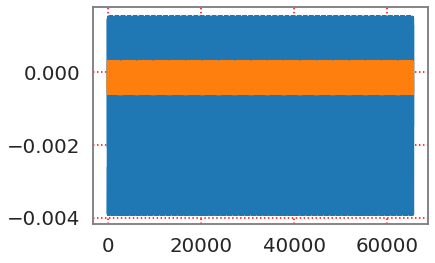

In [34]:
plt.plot(rec_x)
plt.plot(rec_y)

In [35]:
Qx = twiss.summary['q1']
qx = Qx % 1
qx = qx if qx < 0.5 else 1 - qx

Qy = twiss.summary['q2']
qy = Qy % 1
qy = qy if qy < 0.5 else 1 - qy

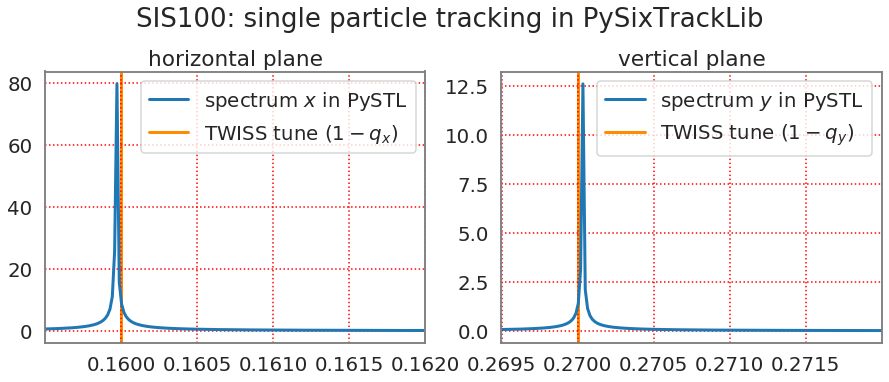

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

plt.sca(ax[0])
plt.title('horizontal plane')
plt.plot(
    np.fft.rfftfreq(len(rec_x)),
    np.abs(np.fft.rfft(rec_x)),
    label=r'spectrum $x$ in PySTL'
)
plt.axvline(qx, color='darkorange', zorder=-1,
            label='TWISS tune $(1-q_x)$')
plt.xlim(qx - 0.0005, qx + 0.002)
plt.legend()

plt.sca(ax[1])
plt.title('vertical plane')
plt.plot(
    np.fft.rfftfreq(len(rec_y)),
    np.abs(np.fft.rfft(rec_y)),
    label=r'spectrum $y$ in PySTL'
)
plt.axvline(qy, color='darkorange', zorder=-1,
            label='TWISS tune $(1-q_y)$')
plt.xlim(qy - 0.0005, qy + 0.002)
plt.legend()

plt.suptitle('SIS100: single particle tracking in PySixTrackLib', y=1.06, fontsize=26);
# plt.savefig('./pystl_sis100_tunes.pdf', bbox_inches='tight')

$\implies$ the alignment errors (offsets and tilts) lead to a finite tune shift